In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from prophet import Prophet
from pyqubo import Array, Constraint, Placeholder
from dwave.system import DWaveSampler, EmbeddingComposite
import numpy as np

C:\Users\waiso\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


<h2>Fetching Data and Pre-processing</h2>

In [2]:
# Step 1: Get the data from yahoo finance
# For this demo, we will get 20 assets from the S&P asset pool.
# We will have two objective functions (One to maximize the profit returns), the other one is to minimize the risk
tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'META', 'GOOGL', 'GOOG', 'LLY', 'AVGO',
           'JPM', 'V', 'UNH', 'TSLA', 'XOM', 'MA', 'JNJ', 'PG', 'HD', 'COST', 'ABBV']

In [3]:
# We choose to focus on 'Ajd Close'as it help investors knows the fair value of the stock after the corporate action is announced and also helps maintain an accurate record of where the stock price starts and where it ends so we choose to the analysis of it instead of closing price.
data = yf.download(tickers, start="2023-01-01", end="2023-03-17")['Adj Close']
data_test = yf.download(tickers, start="2024-01-01", end="2024-03-17")['Adj Close']

[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  20 of 20 completed


In [4]:
# Drop the NaN columns
returns = data.pct_change().dropna()
returns_test = data_test.dropna(inplace=True)

In [5]:
# Find the cov and corr matrix of the returns
# use covariance and correlation matrix to understand how the portfolio assets relate to each other, it’s important because we want our portfolio to be diversified, imagine there is a market crash and all assets are related in a similar manner hence the investor would only incur a loss, whereas if the assets are related in an opposite manner then some assets might produce enormous gains which would counterbalance the loss incurred by majority of the assets.
cov_matrix = returns.cov()
corr_matrix = returns.corr()
expected_returns = returns.mean()
# Can be varried
risk_free_rate = 0.05

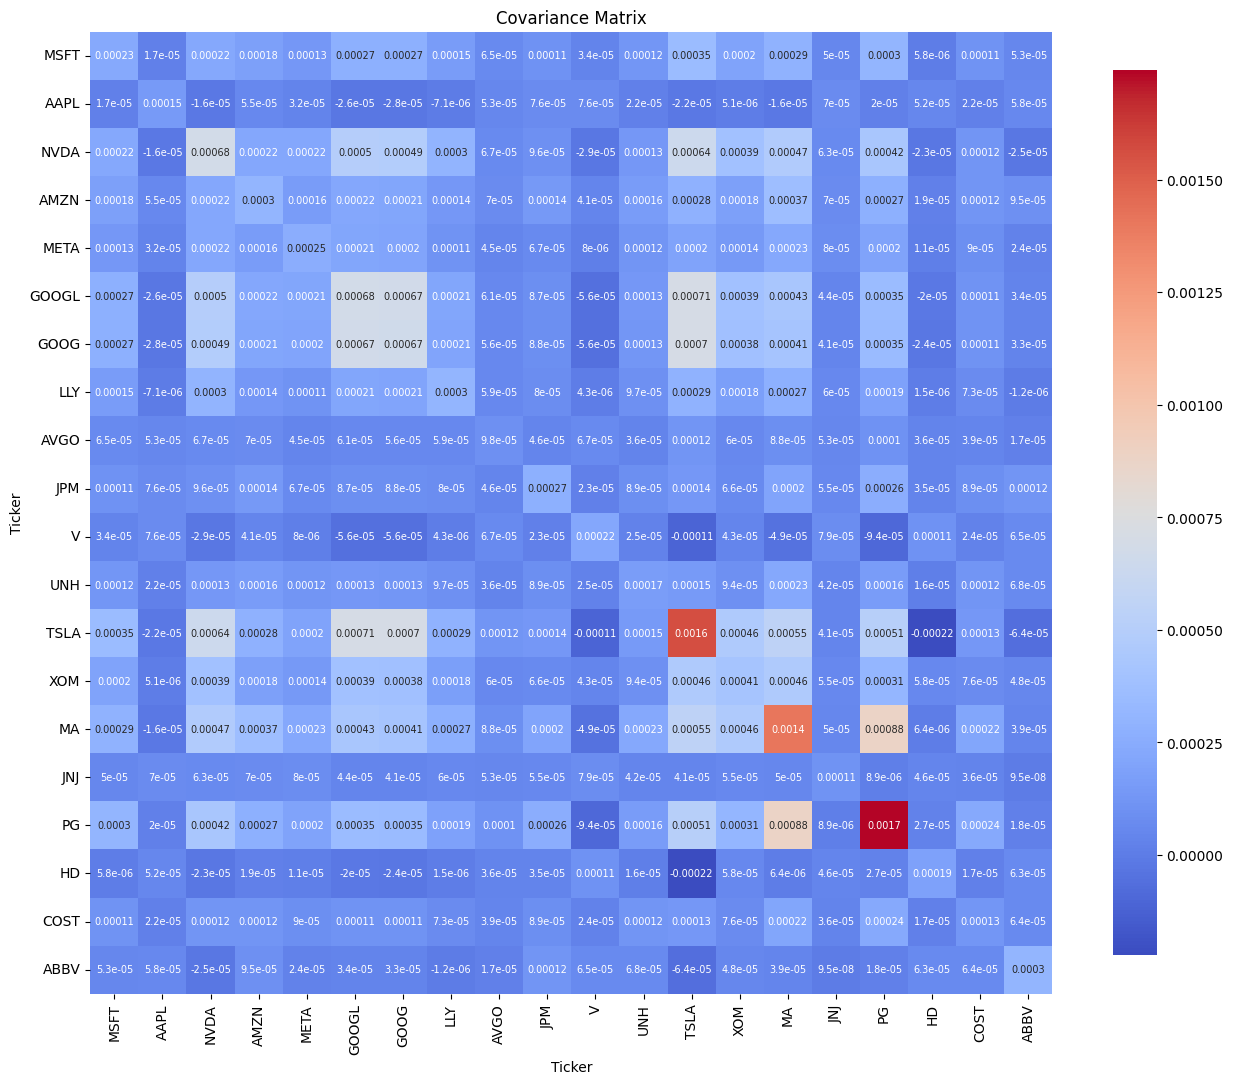

In [23]:
# Visualize Heatmaps of Cov and Corr matrix
# Covariance tells you that two variables change the same way while correlation reveals how a change in one variable affects a change in the other.
plt.figure(figsize=(25, 18))
plt.subplot(1, 2, 1)
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', cbar=True, square=True,
            xticklabels=tickers, yticklabels=tickers, annot_kws={"size": 7}, cbar_kws={'shrink': 0.5})
plt.title('Covariance Matrix')
plt.tight_layout()
plt.show()

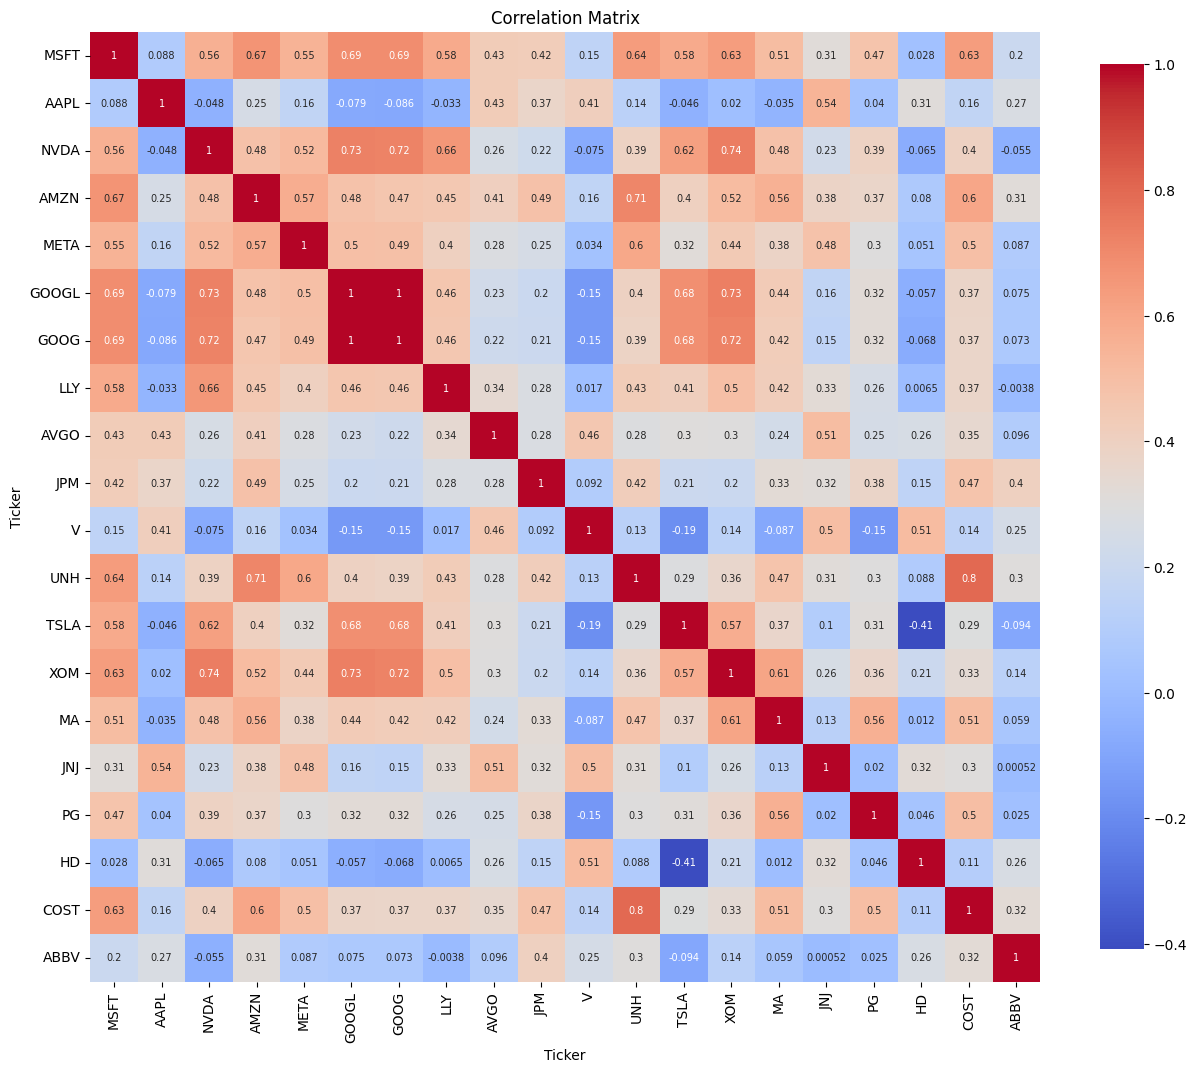

In [6]:
# A correlation of +1 means positive relation, 
# i.e, if the correlation between Asset A and Asset B is 1, if Asset A increases, Asset B increases. 
# A correlation of 0 means no relation.

plt.figure(figsize=(25, 18))
plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True, square=True,
            xticklabels=tickers, yticklabels=tickers, annot_kws={"size": 7}, cbar_kws={'shrink': 0.5})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

<h2>Define Quantum Circuit(Portfolio Optimization)</h2>

In [7]:
# Step 2: Define the Quantum Circuit

mu = expected_returns  # expected returns of the assets
num_stocks = 5  # number of stocks to include in the portfolio
# DWAVE_TOKEN = "YOUR_DWAVE_TOKEN"
DWAVE_TOKEN = 'DEV-b60b8fddddc718bb58084fddcf5a220dce4a939a'

In [8]:
# Quantum Annealing Portfolio Optimization

def quantum_annealing_portfolio_optimization(mu, data, data_test, tickers, num_stocks, dwave_token=DWAVE_TOKEN):
    data = data.copy()  # Create a copy of data
    data_test = data_test.copy()  # Create a copy of data_test
    num_assets = len(mu)
    pred_return_rate = []
    pred_return_rate_mean = []

    for i in range(num_assets):
        model = Prophet()
        data['ds'] = data.index
        data['y'] = data.iloc[:, i]
        stock_data = data[['ds', 'y']]
        model.fit(stock_data)
        future = model.make_future_dataframe(periods=data_test.shape[0])
        forecast = model.predict(future)['yhat']
        return_rate = np.zeros(len(forecast))

        for j in range(len(forecast) - 1):
            return_rate[j+1] = (forecast[j+1] - forecast[j])/forecast[j]
        pred_return_rate.append(return_rate)
        pred_return_rate_mean.append(np.mean(return_rate))
        data.drop(columns=['ds', 'y'], inplace=True)

    # We also calculate actual return rates from the historical stock price data. 
    # We will use the results for the calculation of covariance that will be used for the second objective function to reduce the risk by diversify the portfolio items to avoid losing it altogethe
    actual_return_rate = []
    actual_return_rate_mean = []
    for i in range(num_assets):
        stock_data = data.iloc[:, i]
        return_rate = np.zeros(len(stock_data))

        for j in range(len(stock_data) - 1):
            return_rate[j+1] = (stock_data[j+1] - stock_data[j])/stock_data[j]
        actual_return_rate.append(return_rate)
        actual_return_rate_mean.append(np.mean(return_rate))

    actual_return_rate_mean_mean = np.mean(actual_return_rate_mean)
    print('actual_return_rate_mean_mean:', actual_return_rate_mean_mean)

    # Finally, we calculate the actual return rates on the test set for the final evaluation.
    actual_return_rate_test = []
    actual_return_rate_mean_test = []
    for i in range(num_assets):
        stock_data = data_test.iloc[:, i]
        return_rate = np.zeros(len(stock_data))

        for j in range(len(stock_data) - 1):
            return_rate[j+1] = (stock_data[j+1] - stock_data[j])/stock_data[j]
        actual_return_rate_test.append(return_rate)
        actual_return_rate_mean_test.append(np.mean(return_rate))

    actual_return_rate_mean_mean_test = np.mean(actual_return_rate_mean_test)
    print('actual_return_rate_mean_mean_test:', actual_return_rate_mean_mean_test)

    # In our portfolio optimisation example, let's assume 1 constraint: the number of stock to be included in the portfolio.
    # In this example, we will use PyQubo, a python library that that can conver the cost function to a quadratic unconstraintbinary optimisation matrix that can be sent to D-wave qunatum annealer.
    x = Array.create('x', shape=num_assets, vartype='BINARY')
    h_const1 = (num_stocks - np.dot(x, x))**2

    # We have set two cost functions to optimise our portfolio. One is to maximise the sum of predicted growth rates that we predicted in the feature engineering section. 
    # Another is to minimise the covariance between each of the stock items to be selected in the portfolio. We then add up two cost functions for QUBO.
    h_cost1 = 0
    h_cost1 -= np.dot(x, pred_return_rate_mean)

    h_cost2 = 0
    for i in range(num_assets):
        for j in range(num_assets):
            h_cost2 += x[i]*x[j]*np.sum((actual_return_rate[i]-actual_return_rate_mean[i])
                                        * (actual_return_rate[j]-actual_return_rate_mean[j]))/len(actual_return_rate[i])
    h_cost = h_cost1 + h_cost2

    # The problem formulation and representation in QUBO format are handled by PyQubo applications. In the lines below, we compile the model using the objective function that needs to be minimised, 
    # and then define the constraint coefficient. to_qubo function generates a QUBO matrix in the dictionary type and an offset value which is an constant value not required for the search for the minimum.
    h = h_cost + Placeholder('l1')*Constraint(h_const1, label='num_stocks')
    model = h.compile()
    feed_dict = {'l1': 2}
    qubo, offset = model.to_qubo(feed_dict=feed_dict)
    print('OFFSET:', offset)

    endpoint = 'https://cloud.dwavesys.com/sapi'
    token = dwave_token
    sampler_dw = DWaveSampler(solver='Advantage_system4.1', token=token)
    sampler_qa = EmbeddingComposite(sampler_dw)
    sampleset_qa = sampler_qa.sample_qubo(qubo, num_reads=10)
    records_qa = sampleset_qa.record

    # First List -- optimised combination, 1 indicates the stock included in the portfolio
    # Second value -- energy state lowest is the optimal solution
    # Third value -- number of occurrence of the solution
    # Last value indicates chain break, the connection between qubits that are broken and fixed by the software. 
    # The ideal solution should have 0
    header_format = "{:^50} {:^20} {:^20} {:^10}"
    row_format = "{:<50} {:<20} {:<20} {:<10}"

    print(header_format.format('List', 'Energy State', 'Num of Occurrences', 'Chain Break'))
    for record in records_qa:
        print(row_format.format(str(record[0]), str(record[1]), str(record[2]), str(record[3])))

    portfolio_candidates_qa = []
    num_stock_counts_qa = []
    record_len = len(records_qa)
    for i in range(record_len):
        portfolio = []
        num_stock_count = 0
        for j in range(num_assets):
            if records_qa[i][0][j] == 1:
                portfolio.append(tickers[j])
                num_stock_count += 1
        portfolio_candidates_qa.append(portfolio)
        num_stock_counts_qa.append(num_stock_count)

    header_format = "{:<50} {:<20} {:<10}"
    row_format = "{:<50} {:<20} {:<10}"

    print(header_format.format('Stocks Picked', 'Num of stocks picked', 'Constraints'))
    for portfolio, num_stocks in zip(portfolio_candidates_qa, num_stock_counts_qa):
        constraints = 'Passed' if num_stocks == 5 else 'Failed'
        print(row_format.format(str(portfolio), str(num_stocks), constraints))

    return portfolio_candidates_qa, num_stock_counts_qa, pred_return_rate_mean, actual_return_rate

In [9]:
# Classical Portfolio Optimisation - MPT (Mean-Variance Optimization Model)

# The portfolio weights (w) are computed using linear algebra operations. 
# It involves the dot product of the inverse covariance matrix and the expected returns, normalized by the dot product of the ones array and the result of another dot product operation. 
# The expected return of the portfolio is calculated as the dot product of the portfolio weights (w) and the expected returns of the assets (mu). 
# The standard deviation of the portfolio is calculating using linear algebra operations involving the covariance matrix (cov_matrix) and the portfolio weights (w). 
# In summary, it performs classical portfolio optimization by computing the optimal weights for assets in the portfolio, along with the expected return and standard deviation of the resulting portfolio.

def classical_portfolio_optimization(mu, cov_matrix, risk_free_rate):
    num_assets = len(mu)
    ones = np.ones(num_assets)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    expected_return = mu - risk_free_rate * ones
    w = np.dot(inv_cov_matrix, expected_return) / np.dot(ones, np.dot(inv_cov_matrix, expected_return))
    portfolio_return = np.dot(w, mu)
    portfolio_std_dev = np.sqrt(np.dot(w, np.dot(cov_matrix, w)))

    # Find the indices of top 'num_stocks' assets based on weights
    top_assets_indices = np.argsort(w)[::-1][:num_stocks]

    # Get the tickers of the top assets
    selected_stocks = [tickers[i] for i in top_assets_indices]

    return w, portfolio_return, portfolio_std_dev, selected_stocks

<h2>Results & Comparison</h2>

In [10]:
# Calculate time taken for quantum annealing
start_time_quantum = time.time()
portfolio_candidates_qa, num_stock_counts_qa, pred_return_rate_mean, actual_return_rate = quantum_annealing_portfolio_optimization(
    mu, data, data_test, tickers, num_stocks, DWAVE_TOKEN)
end_time_quantum = time.time()
time_quantum = end_time_quantum - start_time_quantum

11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:08 - cmdstanpy - INFO - Chain [1] done processing
11:56:08 - cmdstanpy - INFO - Chain [1] start processing
11:56:08 - cmdstanpy - INFO - Chain [1] done processing
11:56:08 - cmdstanpy - INFO - Chain [1] start processing
11:56:08 - cmdstanpy - INFO - Chain [1] done processing
11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1]

actual_return_rate_mean_mean: 0.002260143165453074
actual_return_rate_mean_mean_test: 0.0019354682044291222
OFFSET: 50.0
                       List                            Energy State      Num of Occurrences  Chain Break
[0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1]          -40.94071117343554   1                    0.1       
[0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1]          -40.901753872136375  1                    0.1       
[0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0]          -52.43149367765608   1                    0.0       
[0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1]          -47.31186952478379   1                    0.05      
[0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1]          -30.643898170435858  1                    0.15      
[0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1]          -30.598186859891268  1                    0.15      
[0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1]          -47.23959669866615   1                    0.1       
[0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1]     

In [11]:
# Calculate time taken for classical optimization
start_time_classical = time.time()
weights_classical, expected_return_classical, std_dev_classical, selected_stocks_classical = classical_portfolio_optimization(
    expected_returns, cov_matrix, risk_free_rate)
end_time_classical = time.time()
time_classical = end_time_classical - start_time_classical

In [13]:
# Print the result for classical
print("Classical Portfolio Optimization Result:")
print("Weights:", weights_classical)
print("Expected Return:", expected_return_classical)
print("Standard Deviation:", std_dev_classical)
print("Selected Stocks:", selected_stocks_classical)

Classical Portfolio Optimization Result:
Weights: [-0.11986308  0.09107996 -0.01461033 -0.1197526   0.01487464 -1.36899281
  1.37144687  0.06877846  0.41945307 -0.03296654 -0.14101098  0.18219995
  0.00849536  0.08136171 -0.02184758  0.16947403 -0.02726348  0.15185474
  0.19245999  0.09482861]
Expected Return: -0.0024946847785464778
Standard Deviation: 0.00685421878591623
Selected Stocks: ['GOOG', 'AVGO', 'COST', 'UNH', 'JNJ']


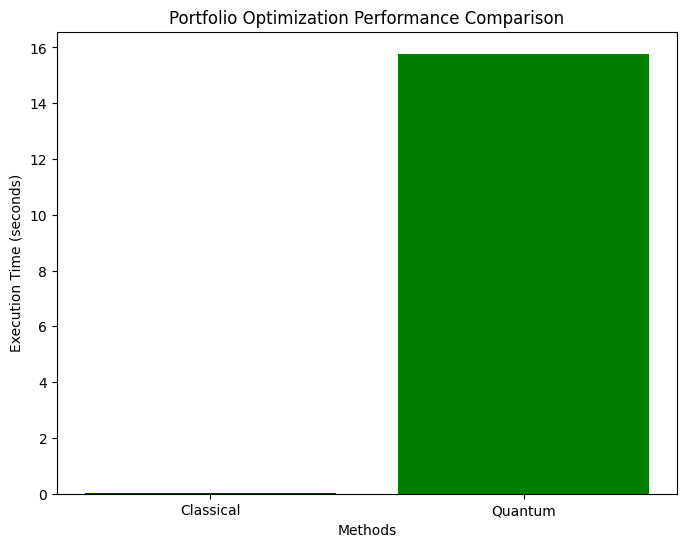

In [12]:
# Performance Comparison
weights_quantum = [1 if ticker in portfolio_candidates_qa[0] else 0 for ticker in tickers]
expected_return_quantum = np.dot(weights_quantum, mu)
std_dev_quantum = np.sqrt(np.dot(weights_quantum, np.dot(cov_matrix, weights_quantum)))

# Compare performance
methods = ['Classical', 'Quantum']
times = [time_classical, time_quantum]

plt.figure(figsize=(8, 6))
plt.bar(methods, times, color=['blue', 'green'])
plt.xlabel('Methods')
plt.ylabel('Execution Time (seconds)')
plt.title('Portfolio Optimization Performance Comparison')
plt.show()

In [13]:
print(
    f"Quantum Annealing Expected Return: {expected_return_quantum}, Classical Expected Return: {expected_return_classical}")
print(
    f"Quantum Annealing Std Dev: {std_dev_quantum}, Classical Std Dev: {std_dev_classical}")

Quantum Annealing Expected Return: 0.013565237848695432, Classical Expected Return: -0.0024946824529984905
Quantum Annealing Std Dev: 0.0916403943575182, Classical Std Dev: 0.0068542202572249075
